<a href="https://colab.research.google.com/github/anmolp1/data_analysis_using_python/blob/master/BigQuery_CitiBike_Trips_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup
---
We set up our Colab by installing, importing, and enabling the usage of a few Python libraries within Colab, as well as authenticating this Colab runtime and then setting up a BigQuery client with the appropriate Cloud project_id. This follows closely the instructions in the ["Getting started with BigQuery"](https://colab.sandbox.google.com/notebooks/bigquery.ipynb#scrollTo=SeTJb51SKs_W)
example Colab.

In [ ]:
#@title Install Latest Version of Some Packages
# !pip install --upgrade chart_studio
# !pip install geopandas
# !pip install Shapely
# !pip install matplotlib

In [ ]:
#@title Import Python Libraries & Some Other Setup
# Basic Python data science libraries
import pandas as pd
import numpy as np
import scipy.optimize

# Import and setup for plotly in Colab
#import chart_studio
#import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

# Enable displaying pandas data frames as interactive tables by default
from google.colab import data_table
data_table.enable_dataframe_formatter()

The authentication step in the next cell will require manually going through some pop-up screens and copy/pasting an authentication code from another window back into the cell to complete (on the 1st run; may run automatically thereafter).

In [ ]:
#@title Provide Google Credentials to Colab Runtime
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
#@title Enter Google Cloud/BigQuery Project ID
project_id = 'dbtsample-447813' #@param{type:"string"}

# Package used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

In [ ]:
#@title Get trips data for April 2017 and April 2018 month. Adding Route and Month for clarity
%%bigquery citibike_trips --project {project_id}

/* Subquery to count # of dates w/ valid temperature data by station */
SELECT LEFT(REGEXP_REPLACE(CAST(DATE_TRUNC(starttime, MONTH) AS STRING),'-',''),6) AS yyyymm, CONCAT(start_station_name, ' -> to -> ', end_station_name) AS route, * FROM `bigquery-public-data.new_york_citibike.citibike_trips` WHERE DATE_TRUNC(starttime, MONTH) IN ('2017-04-01','2018-04-01') AND stoptime IS NOT NULL AND birth_year IS NOT NULL


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#@title Calculate Distance Between Stations
# We can calculate the distance between the start and end stations using the Haversine formula, which accounts for the curvature of the Earth

#citibike_trips

import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Example usage with your dataframe (df)
citibike_trips['distance_km'] = haversine(
    citibike_trips['start_station_latitude'],
    citibike_trips['start_station_longitude'],
    citibike_trips['end_station_latitude'],
    citibike_trips['end_station_longitude']
)

In [ ]:
citibike_trips['distance_km'] = citibike_trips['distance_km'].round(2)
citibike_trips['distance_km'].head()

,distance_km
0,3.23
1,1.85
2,1.85
3,0.64
4,2.57


In [ ]:
import datetime as dt
max_year = citibike_trips['starttime'].max().year
max_year

2018

In [ ]:
#@title Check for null values in the dataset
#citibike_trips[['tripduration','distance_km']].isnull().sum()
citibike_trips.isnull().sum()
#citibike_trips.count()

,0
yyyymm,0
route,0
tripduration,0
starttime,0
stoptime,0
start_station_id,0
start_station_name,0
start_station_latitude,0
start_station_longitude,0
end_station_id,0


In [ ]:
#@title Treat NULL values in data

# Since birth_year has around 6% null values, we will replace them with mean
common_birth_year = citibike_trips['birth_year'].mean().round(0).astype(int)
#common_birth_year

# Replacing the birth year
citibike_trips['birth_year'].fillna(value=common_birth_year, inplace=True)

#Checking if the null values are replaced
citibike_trips.isnull().sum()

<ipython-input-10-ed40ac3f2789>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  citibike_trips['birth_year'].fillna(value=common_birth_year, inplace=True)


,0
yyyymm,0
route,0
tripduration,0
starttime,0
stoptime,0
start_station_id,0
start_station_name,0
start_station_latitude,0
start_station_longitude,0
end_station_id,0


In [ ]:
from datetime import datetime

# Add day of week
citibike_trips['day_of_week'] = citibike_trips['starttime'].dt.weekday
citibike_trips['day_of_week_name'] = citibike_trips['starttime'].dt.strftime("%A")
#citibike_trips['day_of_week'].unique()


In [ ]:
# Add hour of day
citibike_trips['hour_of_day'] = citibike_trips['starttime'].dt.hour
#citibike_trips['hour_of_day'].unique()

In [ ]:
trips_agg = citibike_trips.groupby(['yyyymm','route','day_of_week_name','bikeid','usertype','birth_year','gender','customer_plan','distance_km','tripduration','start_station_name','hour_of_day'])['starttime'].size().reset_index(name='trips')


In [ ]:
# Identify rows with 'unknown' gender
unknown_gender_rows = trips_agg[trips_agg['gender'] == 'unknown'].index

# Determine the number of rows to fill with 'male' and 'female'
num_rows_to_fill = len(unknown_gender_rows)
num_females = num_rows_to_fill // 2
num_males = num_rows_to_fill - num_females

# Create a list of 'male' and 'female' to fill in
fill_values = ['male'] * num_males + ['female'] * num_females

# Shuffle the fill values randomly
np.random.shuffle(fill_values)

# Fill 'unknown' genders with shuffled values
trips_agg.loc[unknown_gender_rows, 'gender'] = fill_values

#print(trips_agg)

In [ ]:
trips_agg['gender'].value_counts()

,count
gender,
male,1808858
female,645406


In [ ]:
#@title Get duration by month

# Calculate average duration by month
monthly_duration = trips_agg.groupby('yyyymm')['tripduration'].agg(['mean', 'count', 'std']).reset_index()

# Print the specific months we're interested in
april_stats = monthly_duration[monthly_duration['yyyymm'].isin(['201704', '201804'])]
print("Average trip duration by month:")
print(april_stats)

Average trip duration by month:
   yyyymm        mean    count           std
0  201704  931.119438  1146730  23879.112459
1  201804  970.913259  1307534  20312.040958


In [ ]:
# Calculate percentage change
pct_change = ((970.91 - 1085.86) / 1085.86) * 100
print(f"\
Percentage change in duration: {pct_change:.0f}%")

Percentage change in duration: -11%


In [ ]:
# Treat outliers in tripduration
trips_agg['tripduration'] = pd.to_numeric(trips_agg['tripduration'], errors='coerce').round(0)

# Calculate the 95th percentile as the upper limit
upper_limit_duration = trips_agg['tripduration'].quantile(0.90)

# Cap the values above the 95th percentile
trips_agg['tripduration_capped'] = trips_agg['tripduration'].apply(lambda x: upper_limit_duration if x > upper_limit_duration else x)
trips_agg['tripduration_capped'].describe()

,tripduration_capped
count,2.454264e+06
mean,7.262676e+02
std,4.610866e+02
min,6.100000e+01
25%,3.540000e+02
50%,5.930000e+02
75%,1.030000e+03
max,1.614000e+03


In [ ]:
#@title Get duration by month after outlier treatment in tripduration

# Calculate average duration by month
monthly_duration = trips_agg.groupby('yyyymm')['tripduration_capped'].agg(['mean', 'count', 'std']).reset_index()

# Print the specific months we're interested in
april_stats = monthly_duration[monthly_duration['yyyymm'].isin(['201704', '201804'])]
print("Average trip duration by month:")
print(april_stats)

Average trip duration by month:
   yyyymm        mean    count         std
0  201704  719.248364  1146730  449.844879
1  201804  732.423657  1307534  470.638923


In [ ]:
# Calculate percentage change
pct_change = ((768.37 - 818.67) / 818.67) * 100
print(f"\
Percentage change in duration: {pct_change:.0f}%")

Percentage change in duration: -6%


# Conclusion-1: The 11% drop is actually incorrect, and is inflated due to outliers. The actual drop is 6%

In [ ]:
# Let's use the capped duration column instead of the original one:

# Drop the original 'tripduration' column
trips_agg.drop('tripduration', axis=1, inplace=True)

# Rename 'tripduration_capped' to 'tripduration'
trips_agg.rename(columns={'tripduration_capped': 'tripduration'}, inplace=True)
trips_agg.head()

,yyyymm,route,day_of_week_name,bikeid,usertype,birth_year,gender,customer_plan,distance_km,start_station_name,hour_of_day,trips,tripduration
0,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,16213,Subscriber,1960,male,,0.0,1 Ave & E 16 St,18,1,798.0
1,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,16524,Subscriber,1985,male,,0.0,1 Ave & E 16 St,11,1,1131.0
2,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,17910,Subscriber,1960,male,,0.0,1 Ave & E 16 St,10,1,461.0
3,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,17942,Subscriber,1979,female,,0.0,1 Ave & E 16 St,15,1,1614.0
4,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,20280,Subscriber,1998,female,,0.0,1 Ave & E 16 St,22,1,618.0


In [ ]:
# Let's analyze by user type
user_duration = trips_agg[trips_agg['yyyymm'].isin(['201704', '201804'])].groupby(['yyyymm', 'usertype'])['tripduration'].agg(['mean', 'count']).reset_index()
print("\
Duration by user type:")
user_duration

Duration by user type:


,yyyymm,usertype,mean,count
0,201704,Customer,1187.796302,31046
1,201704,Subscriber,706.210138,1115684
2,201804,Customer,1202.137130,149311
3,201804,Subscriber,671.871079,1158223


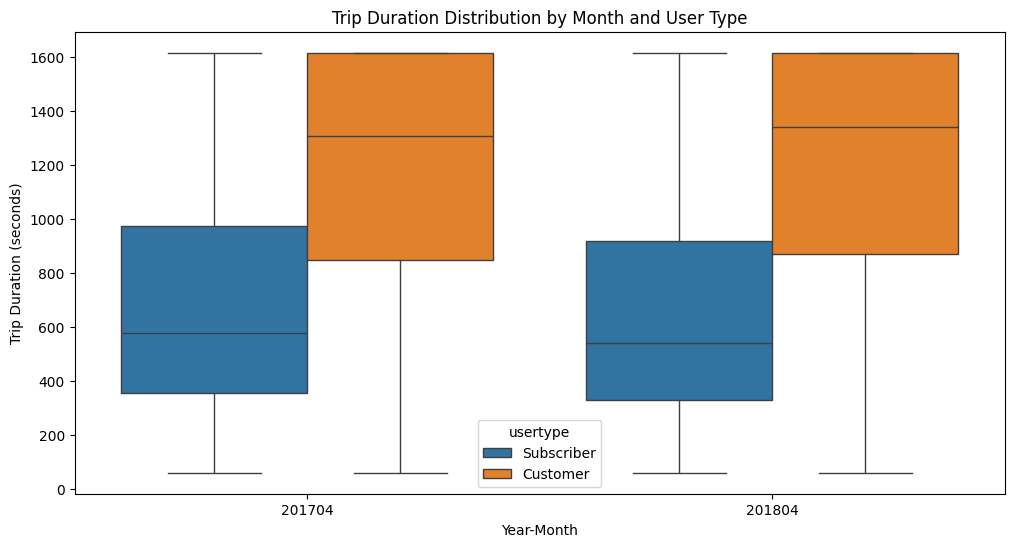

In [ ]:
# Create a box plot to show distribution of trip durations by month and user type
plt.figure(figsize=(12, 6))
sns.boxplot(data=trips_agg[trips_agg['yyyymm'].isin(['201704', '201804'])],
            x='yyyymm',
            y='tripduration',
            hue='usertype',
            showfliers=False)  # Exclude outliers for better visualization
plt.title('Trip Duration Distribution by Month and User Type')
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Year-Month')
plt.show()

In [ ]:
# Analyze trip patterns by route
station_stats = trips_agg[trips_agg['yyyymm'].isin(['201704', '201804'])].groupby(['yyyymm', 'route'])['tripduration'].agg(['mean', 'count']).reset_index()

# Find routes with significant changes
station_pivot = station_stats.pivot(index='route', columns='yyyymm', values='mean')
station_pivot['pct_change'] = ((station_pivot['201804'] - station_pivot['201704']) / station_pivot['201704']) * 100

# Get top stations with biggest changes
print("\
Top 10 stations with largest decrease in average trip duration:")
print(station_pivot.sort_values('pct_change').head(10))

Top 10 stations with largest decrease in average trip duration:
yyyymm                                                   201704      201804  \
route                                                                         
Cadman Plaza West & Montague St -> to -> Fulton...  1256.333333   68.166667   
Bus Slip & State St -> to -> Water - Whitehall ...  1614.000000   92.000000   
E 44 St & 2 Ave -> to -> 1 Ave & E 44 St            1614.000000   93.250000   
South St & Whitehall St -> to -> Water - Whiteh...  1614.000000   94.888889   
Madison Ave & E 99 St -> to -> E 102 St & Park Ave  1216.000000   76.000000   
Carlton Ave & Park Ave -> to -> Clermont Ave & ...  1175.000000   77.500000   
Columbus Ave & W 103 St -> to -> W 106 St & Cen...  1475.000000  120.000000   
Division Ave & Hooper St -> to -> Division Ave ...  1250.250000  106.000000   
14 St & 5 Ave -> to -> 6 Ave & 12 St                1614.000000  146.500000   
Water - Whitehall Plaza -> to -> Bus Slip & Sta...   870.000000   8

In [ ]:
trips_agg['distance_km'].describe()

,distance_km
count,2.454264e+06
mean,1.811263e+00
std,5.707570e+00
min,0.000000e+00
25%,8.500000e-01
50%,1.400000e+00
75%,2.340000e+00
max,8.663340e+03


In [ ]:
upper_limit = trips_agg['distance_km'].quantile(0.95)
trips_agg['distance_km_capped'] = trips_agg['distance_km'].apply(lambda x: upper_limit if x > upper_limit else x)
trips_agg.drop('distance_km', axis=1, inplace=True)
trips_agg.rename(columns={'distance_km_capped': 'distance_km'}, inplace=True)
trips_agg['distance_km'] = trips_agg['distance_km'].round(3)
trips_agg['distance_km'].describe()

,distance_km
count,2.454264e+06
mean,1.740574e+00
std,1.203823e+00
min,0.000000e+00
25%,8.500000e-01
50%,1.400000e+00
75%,2.340000e+00
max,4.700000e+00


In [ ]:
trips_agg.shape

(2454264, 13)

In [ ]:
list(trips_agg.columns.values)

['yyyymm',
 'route',
 'day_of_week_name',
 'bikeid',
 'usertype',
 'birth_year',
 'gender',
 'customer_plan',
 'start_station_name',
 'hour_of_day',
 'trips',
 'tripduration',
 'distance_km']

In [ ]:
trips_agg.head()

,yyyymm,route,day_of_week_name,bikeid,usertype,birth_year,gender,customer_plan,start_station_name,hour_of_day,trips,tripduration,distance_km
0,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,16213,Subscriber,1960,male,,1 Ave & E 16 St,18,1,798.0,0.0
1,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,16524,Subscriber,1985,male,,1 Ave & E 16 St,11,1,1131.0,0.0
2,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,17910,Subscriber,1960,male,,1 Ave & E 16 St,10,1,461.0,0.0
3,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,17942,Subscriber,1979,female,,1 Ave & E 16 St,15,1,1614.0,0.0
4,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,20280,Subscriber,1998,female,,1 Ave & E 16 St,22,1,618.0,0.0


In [ ]:
trips_monthly_val = trips_agg.pivot_table(index=[
 'route',
 'day_of_week_name',
 'bikeid',
 'usertype',
 'birth_year',
 'gender',
 'customer_plan',
 'tripduration',
 'distance_km',
 'start_station_name'],columns='yyyymm', values='trips')
trips_monthly_val.reset_index(inplace=True)
trips_monthly_val[['201704','201804']] = trips_monthly_val[['201704','201804']].fillna(0)
trips_monthly_val.shape



(2454015, 12)

In [ ]:
trips_monthly_val2 = trips_monthly_val.groupby(['route',
 'day_of_week_name',
 'bikeid',
 'usertype',
 'birth_year',
 'gender',
 'customer_plan',
 'tripduration',
 'distance_km',
 'start_station_name']).aggregate({'201704': 'sum', '201804': 'sum'}).reset_index()

In [ ]:
trips_monthly_val2.describe()

yyyymm,bikeid,birth_year,tripduration,distance_km,201704,201804
count,2454015.0,2454015.0,2.454015e+06,2.454015e+06,2.454015e+06,2.454015e+06
mean,24989.544769,1978.477586,7.261806e+02,1.740735e+00,4.672596e-01,5.327447e-01
std,5557.67748,11.909235,4.610243e+02,1.203755e+00,4.989286e-01,4.989344e-01
min,14529.0,1885.0,6.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,19607.0,1969.0,3.540000e+02,8.500000e-01,0.000000e+00,0.000000e+00
50%,26536.0,1981.0,5.930000e+02,1.400000e+00,0.000000e+00,1.000000e+00
75%,29055.0,1988.0,1.030000e+03,2.340000e+00,1.000000e+00,1.000000e+00
max,33671.0,2002.0,1.614000e+03,4.700000e+00,2.000000e+00,3.000000e+00


In [ ]:
#@title Export dataset to be further visualised in Tableau
trips_monthly_val2.to_csv("/trips_monthly_val2.csv", index=False)

In [ ]:
# Age of customers
trips_agg['birth_year'] = pd.to_numeric(trips_agg['birth_year'], errors='coerce').round(0)
trips_agg['age'] = max_year - trips_agg['birth_year']

# Calculate the total number of trips duration for birth_year
total_trips_by_birth_year = trips_agg.groupby('age')['trips'].sum().reset_index()
total_trips_by_birth_year = total_trips_by_birth_year.sort_values('trips', ascending=False)
# Create the bar chart using plotly express
fig = px.bar(total_trips_by_birth_year, x='age', y='trips')
fig.update_traces(marker_color='darkgreen')
fig.show()

In [ ]:
#trips_agg['age'] = pd.to_numeric(trips_agg['age'], errors='coerce').round(0)

# Calculate the 95th percentile as the upper limit
upper_limit_age = trips_agg['age'].quantile(0.95)

print(f"95th percentile: {upper_limit_age}")  # Verify the calculated percentile

# Cap the values above the 95th percentile
trips_agg['age_capped'] = trips_agg['age'].apply(lambda x: upper_limit_age if x > upper_limit_age else x)

# Drop the original 'age' column
trips_agg.drop('age', axis=1, inplace=True)

# Rename 'age_capped' to 'age'
trips_agg.rename(columns={'age_capped': 'age'}, inplace=True)

95th percentile: 61.0


In [ ]:
# Calculate the total number of trips duration for birth_year
total_trips_by_birth_year = trips_agg.groupby('age')['trips'].sum().reset_index()
total_trips_by_birth_year = total_trips_by_birth_year.sort_values('trips', ascending=False)
# Create the bar chart using plotly express
fig = px.bar(total_trips_by_birth_year, x='age', y='trips')
fig.update_traces(marker_color='darkgreen')
fig.show()

In [ ]:
total_trips_by_birth_year_2017 = trips_agg[trips_agg['yyyymm'] == '201704']

# Calculate the total number of trips duration for age
total_trips_by_birth_year_2017 = total_trips_by_birth_year_2017.groupby('age')['tripduration'].mean().reset_index()
total_trips_by_birth_year_2017 = total_trips_by_birth_year_2017.sort_values('tripduration', ascending=False)
# Create the bar chart using plotly express
fig = px.bar(total_trips_by_birth_year_2017, x='age', y='tripduration')
fig.update_traces(marker_color='darkgreen')
fig.show()

In [ ]:
total_trips_by_birth_year_2018 = trips_agg[trips_agg['yyyymm'] == '201804']

# Calculate the total number of trips duration for age
total_trips_by_birth_year_2018 = total_trips_by_birth_year_2018.groupby('age')['tripduration'].mean().reset_index()
total_trips_by_birth_year_2018 = total_trips_by_birth_year_2018.sort_values('tripduration', ascending=False)
# Create the bar chart using plotly express
fig = px.bar(total_trips_by_birth_year_2018, x='age', y='tripduration')
fig.update_traces(marker_color='red')
fig.show()

In [ ]:
#@title Insight: There is a significant increase in the avg tripduration from 9AM to 5PM in 2018 wrt 2017 April. Additionally, there is a decline after 5PM

# Add trends for days and hours

# Calculate the avg trips duration for time of day
avg_duration_hour = trips_agg.groupby(['hour_of_day','yyyymm'])['tripduration'].mean().reset_index()
#avg_duration_hour = avg_duration_hour.sort_values('tripduration', ascending=False)

# Create the line plot using Plotly Express
fig = px.line(avg_duration_hour, x='hour_of_day', y='tripduration', color='yyyymm',
              title='Trend of Trip Duration by Hour of Day')

fig.show()

In [ ]:
#@title Insight: The mean trip duration increased by 17% on Saturdays. In 2018, it is 923 wrt 785 in 2017

# Add trends for days and hours

# Calculate the avg trips duration for time of day
avg_duration_day = trips_agg.groupby(['day_of_week_name','yyyymm'])['tripduration'].mean().reset_index()

# Create the line plot using Plotly Express
fig = px.bar(avg_duration_day,
              x='day_of_week_name',
              y='tripduration',
              color='yyyymm',
              barmode = 'group',
              title='Trend of Trip Duration by Day of Week',
              category_orders={"day_of_week_name": [ "Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]})

fig.show()

<ipython-input-41-a6e1f21dfe46>:7: FutureWarning:

The provided callable <function mean at 0x7bae859f8d60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



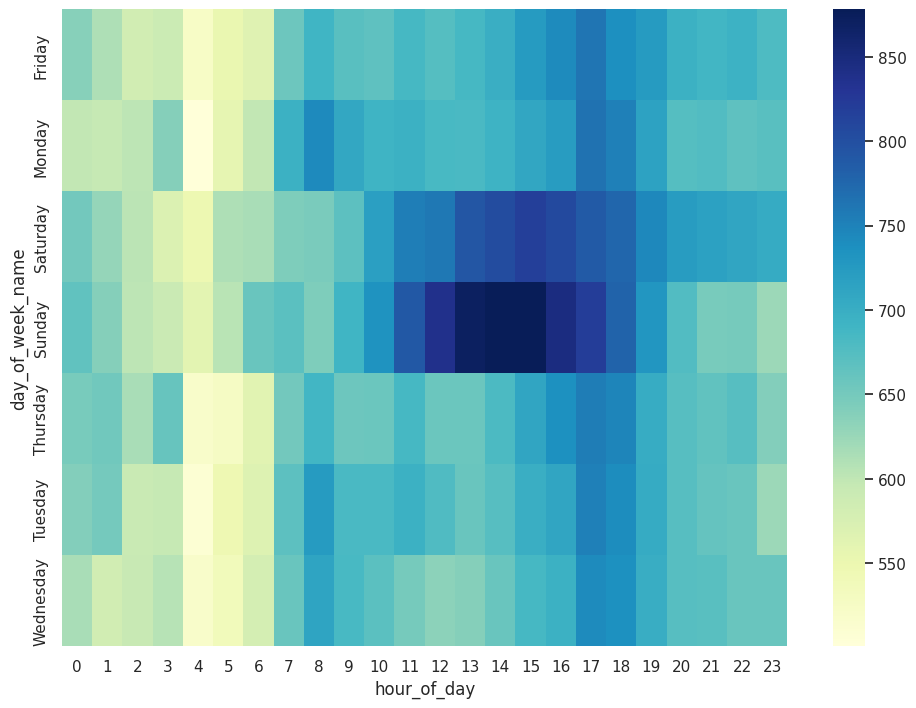

<ipython-input-41-a6e1f21dfe46>:13: FutureWarning:

The provided callable <function mean at 0x7bae859f8d60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



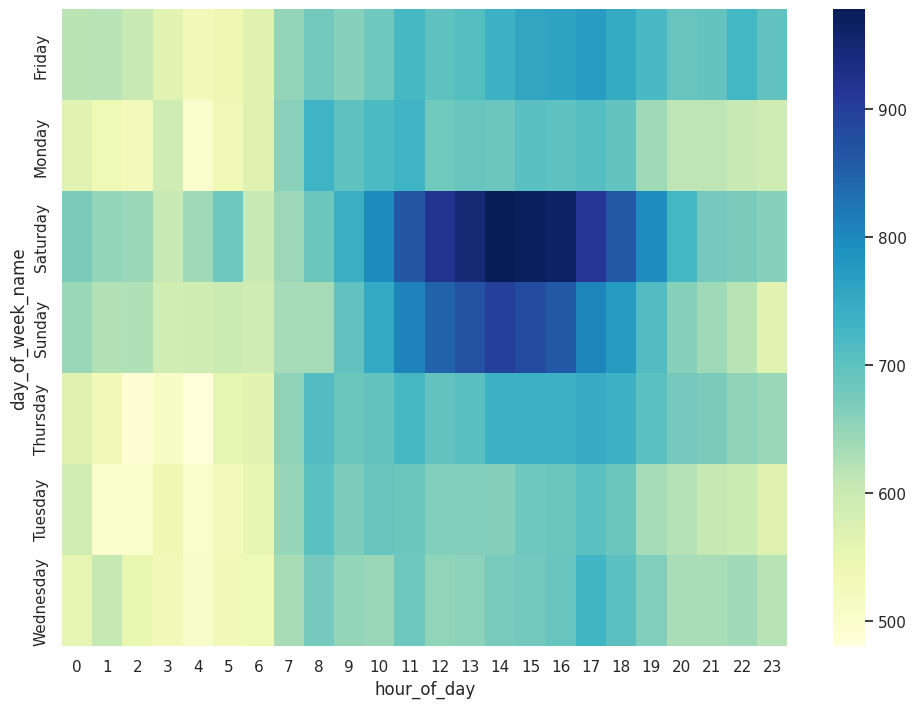

In [ ]:
# Busiest time by day and hour : 2017 vs 2018

trips_agg_2017 = trips_agg[trips_agg['yyyymm'] == '201704']

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

heatmap_2017 = trips_agg_2017.pivot_table(values='tripduration',index='day_of_week_name',columns='hour_of_day',aggfunc=np.mean)
sns.heatmap(heatmap_2017,annot=False,cmap='YlGnBu')
plt.show()

trips_agg_2018 = trips_agg[trips_agg['yyyymm'] == '201804']

heatmap_2018 = trips_agg_2018.pivot_table(values='tripduration',index='day_of_week_name',columns='hour_of_day',aggfunc=np.mean)
sns.heatmap(heatmap_2018,annot=False,cmap='YlGnBu')
plt.show()

(array([221620., 442354., 415807., 318567., 232914., 173821., 135902.,
        107380.,  87893., 318006.]),
 array([  61. ,  216.3,  371.6,  526.9,  682.2,  837.5,  992.8, 1148.1,
        1303.4, 1458.7, 1614. ]),
 <BarContainer object of 10 artists>)

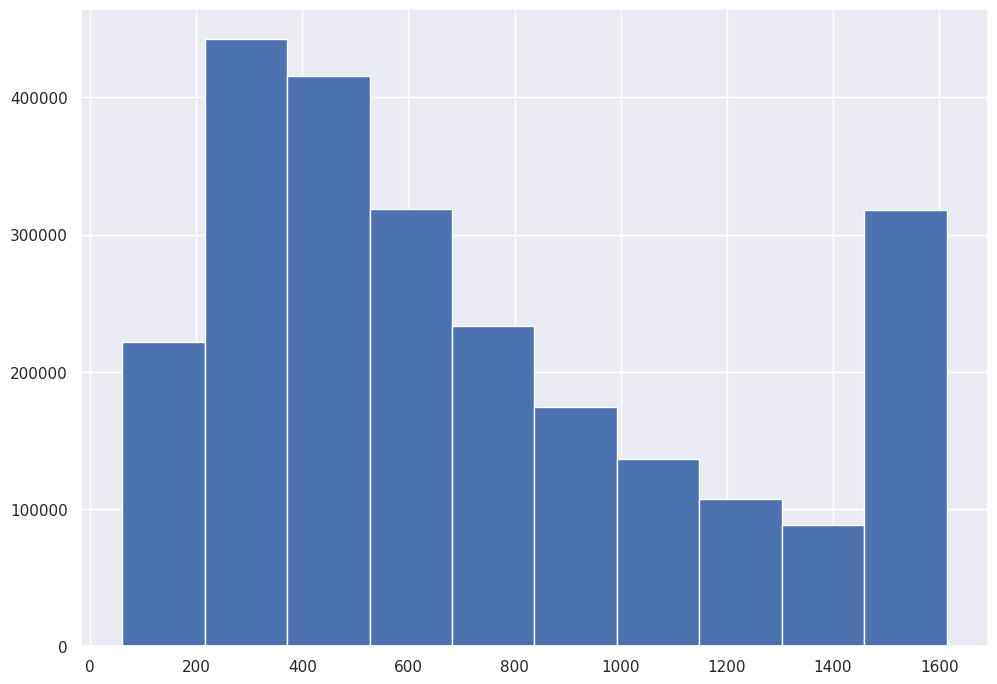

In [ ]:
plt.hist(trips_agg['tripduration'])

<ipython-input-43-1b556fa62a2e>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='tripduration', ylabel='Density'>

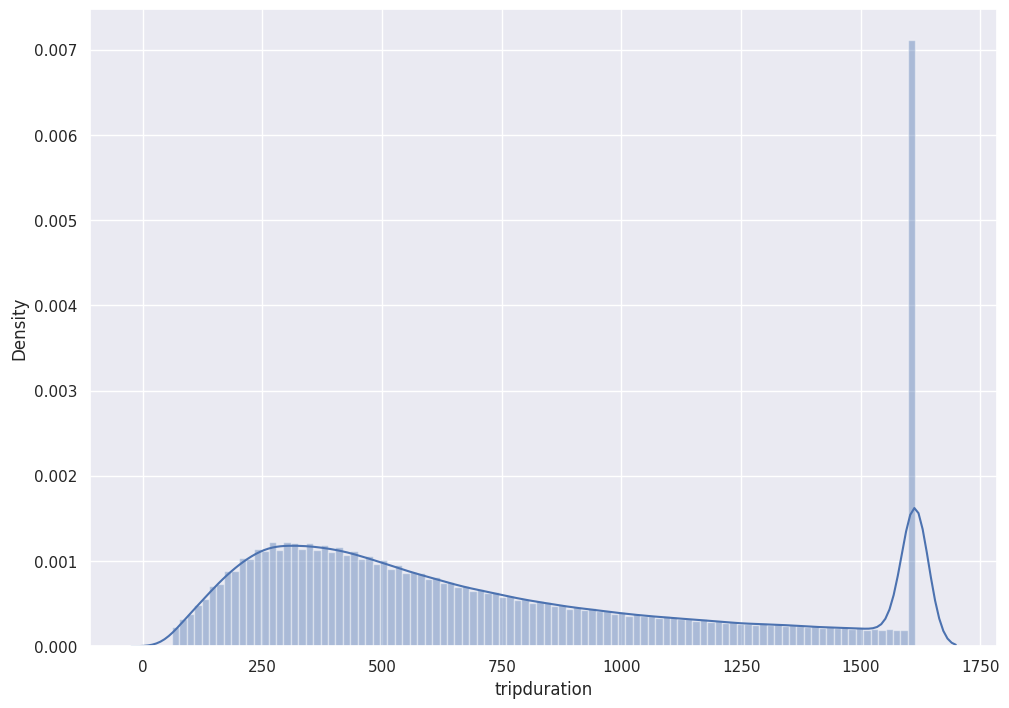

In [ ]:
sns.distplot(trips_agg_2018['tripduration'], kde=True, bins=100)

<ipython-input-44-8fb946d0346c>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='tripduration', ylabel='Density'>

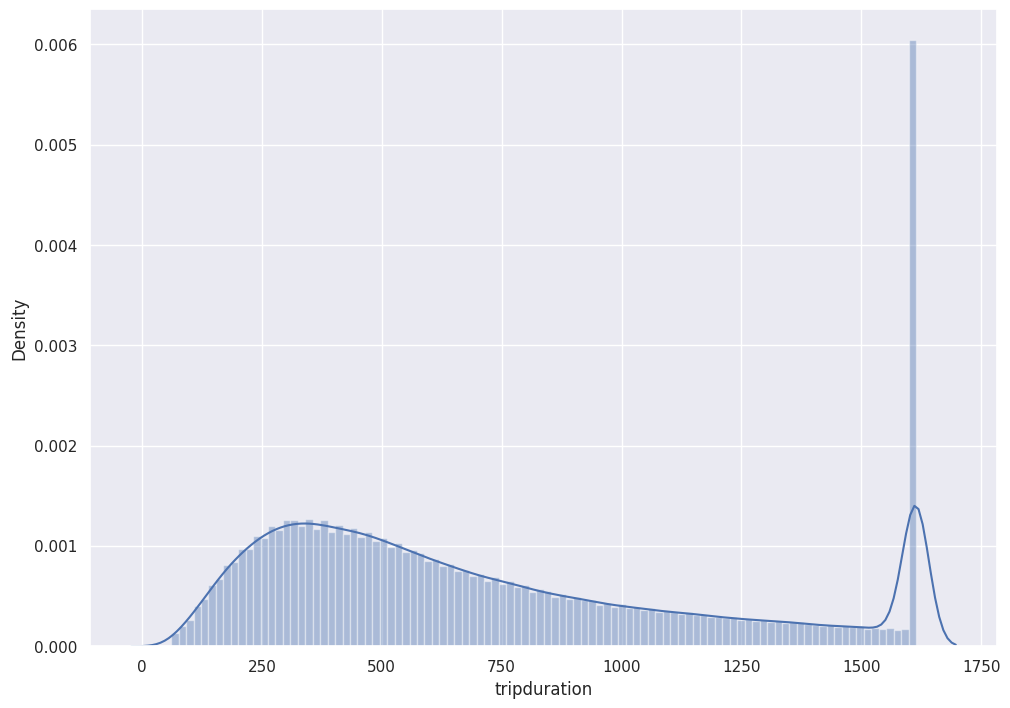

In [ ]:
sns.distplot(trips_agg_2017['tripduration'], kde=True, bins=100)

In [ ]:
upper_level_limit_td = trips_agg['tripduration'].quantile(0.95)
upper_level_limit_td

1614.0

In [ ]:
trips_agg.head(10)

,yyyymm,route,day_of_week_name,bikeid,usertype,birth_year,gender,customer_plan,start_station_name,hour_of_day,trips,tripduration,distance_km,age
0,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,16213,Subscriber,1960,male,,1 Ave & E 16 St,18,1,798.0,0.0,58.0
1,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,16524,Subscriber,1985,male,,1 Ave & E 16 St,11,1,1131.0,0.0,33.0
2,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,17910,Subscriber,1960,male,,1 Ave & E 16 St,10,1,461.0,0.0,58.0
3,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,17942,Subscriber,1979,female,,1 Ave & E 16 St,15,1,1614.0,0.0,39.0
4,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,20280,Subscriber,1998,female,,1 Ave & E 16 St,22,1,618.0,0.0,20.0
5,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,20360,Subscriber,1977,female,,1 Ave & E 16 St,18,1,621.0,0.0,41.0
6,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,21492,Subscriber,1978,male,,1 Ave & E 16 St,14,1,1614.0,0.0,40.0
7,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,24962,Subscriber,1998,female,,1 Ave & E 16 St,15,1,1614.0,0.0,20.0
8,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,25435,Subscriber,1978,male,,1 Ave & E 16 St,15,1,1614.0,0.0,40.0
9,201704,1 Ave & E 16 St -> to -> 1 Ave & E 16 St,Friday,26758,Subscriber,1978,female,,1 Ave & E 16 St,15,1,1614.0,0.0,40.0


In [ ]:
#@title Random Forest/ Gradient Boosting

# Preprocessing

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

cat_features = ['route', 'day_of_week_name', 'gender', 'customer_plan', 'start_station_name']
num_features = ['bikeid', 'birth_year', 'distance_km']  # Add your numerical features here

# Create a preprocessor to handle categorical and numerical features separately
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),  # Passthrough for numerical features
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_features), # OneHotEncoder for categorical features with sparse=False to avoid sparse matrix and handle_unknown='ignore' to ignore unknown categories during prediction
    ])

# Apply the preprocessor to your data
X = preprocessor.fit_transform(trips_agg.drop(columns=['tripduration']))
y = trips_agg['tripduration']

In [ ]:
!jupyter nbconvert --to script "/BigQuery_CitiBike_Trips_Data_Analysis.ipynb"

[NbConvertApp] WARNING | pattern '/BigQuery_CitiBike_Trips_Data_Analysis.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.ans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')